In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('../')

In [ ]:
import gc
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from clearml import Task
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary
from torch import nn
from torch.utils.data import DataLoader
from transformers import GPT2Config, GPT2Model

from src.datasets import CausalLMDataset, CausalLMPredictionDataset, PaddingCollateFn
from src.models import SASRec
from src.modules import SeqRec, SeqRecWithSampling

from src.metrics import Evaluator
from src.postprocess import preds2recs
from src.preprocess import add_time_idx, filter_items, filter_users
from src.utils import extract_validation_history

from sklearn.model_selection import train_test_split

## Load data

In [5]:
# data_path='../data/ml-1m.csv'
data_path='../data/ml-20m.csv'

data = pd.read_csv(data_path)
data = add_time_idx(data)

train = data[data.time_idx_reversed >= 10]
test = data[data.time_idx_reversed < 10]

users_validation, users_test = train_test_split(
    test.user_id.unique(), test_size=0.5, random_state=42)
validation = test[test.user_id.isin(users_validation)]
test = test[test.user_id.isin(users_test)]

train = add_time_idx(train)
validation = add_time_idx(validation)
test = add_time_idx(test)

train2 = train[train.user_id.isin(users_validation)]
validation2 = validation[validation.time_idx == 0]
validation_full = pd.concat([train2, validation2])
validation_full = add_time_idx(validation_full)

## Dataloaders

In [17]:
MAX_LENGTH = 128
NUM_NEGATIVES = 1
FULL_NEGATIVE_SAMPLING = True

VALIDATION_SIZE = 2000
# VALIDATION_SIZE = None

BATCH_SIZE = 64
TEST_BATCH_SIZE = 256
NUM_WORKERS = 8

In [18]:
train_dataset = CausalLMDataset(train, max_length=MAX_LENGTH,
                                num_negatives=NUM_NEGATIVES,
                                full_negative_sampling=FULL_NEGATIVE_SAMPLING)

validation_users = validation_full.user_id.unique()
if VALIDATION_SIZE:
    np.random.seed(42)
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
eval_dataset = CausalLMPredictionDataset(validation_full[validation_full.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True)
collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

## Model

In [19]:
SASREC_CONFIG = {
    'maxlen': 128,
    'hidden_units': 256,
    'num_blocks': 2,
    'num_heads': 1,
    'dropout_rate': 0.1,
}

In [23]:
model = SASRec(item_num=train.item_id.max(), **SASREC_CONFIG, add_head=False)

## Train

In [21]:
TRAINER_PARAMS = {
    'max_epochs': 100,
    'gpus': 1,
    'enable_checkpointing': True,
}

In [ ]:
seqrec_module = SeqRecWithSampling(model, lr=0.001, predict_top_k=10, loss='bce')

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=15, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
callbacks=[early_stopping, model_summary, checkpoint]

trainer = pl.Trainer(callbacks=callbacks, **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

   | Name                              | Type                            | Params
---------------------------------------------------------------------------------------
0  | model                             | SASRec                          | 34.4 M
1  | model.item_emb                    | Embedding                       | 33.6 M
2  | model.pos_emb                     | Embedding                       | 32.8 K
3  | model.emb_dropout                 | Dropout                         | 0     
4  | model.attention_layernorms        | ModuleList                      | 1.0 K 
5  | model.attention_layernorms.0      | LayerNorm     

Epoch 0: 100%|████████████████████████████████████████████████▊| 2164/2172 [00:52<00:00, 41.17it/s, loss=0.131, v_num=7]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.45it/s]
Epoch 0: 100%|█| 2172/2172 [00:57<00:00, 37.75it/s, loss=0.131, v_num=7, val_ndcg=0.0643, val_hit_rate=0.131, val_mrr=0.
Epoch 1: 100%|▉| 2164/2172 [00:52<00:00, 40.97it/s, loss=0.117, v_num=7, val_ndcg=0.0643, val_hit_rate=0.131, val_mrr=0.
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████▌                                                    | 1/8 [00:00<00:02,  2.47it/s]
Epoch 1: 100%|▉| 2165/2172 [00:54<00:00, 39.49it/s, loss=0.117, v_num=7, val_ndcg=0.0643, val_hit_rate=0.131, val_mrr=0.
Validation DataLoader 0:  25%|███████████████                                             | 2/8 [00:00<00:02,  2.46it/s]
Epoch 1: 100%|▉| 2166/2172 [00:55<00:00, 39.22it/s, loss=0.117, v_num=7, val_ndcg=0.0643, v

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 23: 100%|▉| 2164/2172 [00:52<00:00, 41.00it/s, loss=0.081, v_num=7, val_ndcg=0.109, val_hit_rate=0.215, val_mrr=0.
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████▌                                                    | 1/8 [00:00<00:02,  2.46it/s]
Epoch 23: 100%|▉| 2165/2172 [00:54<00:00, 39.56it/s, loss=0.081, v_num=7, val_ndcg=0.109, val_hit_rate=0.215, val_mrr=0.
Validation DataLoader 0:  25%|███████████████                                             | 2/8 [00:00<00:02,  2.46it/s]
Epoch 23: 100%|▉| 2166/2172 [00:55<00:00, 39.29it/s, loss=0.081, v_num=7, val_ndcg=0.109, val_hit_rate=0.215, val_mrr=0.
Validation DataLoader 0:  38%|██████████████████████▌                                     | 3/8 [00:01<00:02,  2.47it/s]
Epoch 23: 100%|▉| 2167/2172 [00:55<00:00, 39.02it/s, loss=0.081, v_num=7, val_ndcg=0.109, val_hit_rate=0.215, val_mrr=0.
Validation DataLoader 0:  50%|██████████████████████████████                              | 4/8 [00:01<00:01,  2.45it/s]
E

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 37: 100%|▉| 2164/2172 [00:52<00:00, 40.97it/s, loss=0.0769, v_num=7, val_ndcg=0.114, val_hit_rate=0.223, val_mrr=0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████▌                                                    | 1/8 [00:00<00:02,  2.44it/s]
Epoch 37: 100%|▉| 2165/2172 [00:54<00:00, 39.50it/s, loss=0.0769, v_num=7, val_ndcg=0.114, val_hit_rate=0.223, val_mrr=0
Validation DataLoader 0:  25%|███████████████                                             | 2/8 [00:00<00:02,  2.41it/s]
Epoch 37: 100%|▉| 2166/2172 [00:55<00:00, 39.22it/s, loss=0.0769, v_num=7, val_ndcg=0.114, val_hit_rate=0.223, val_mrr=0
Validation DataLoader 0:  38%|██████████████████████▌                                     | 3/8 [00:01<00:02,  2.44it/s]
Epoch 37: 100%|▉| 2167/2172 [00:55<00:00, 38.95it/s, loss=0.0769, v_num=7, val_ndcg=0.114, val_hit_rate=0.223, val_mrr=0
Validation DataLoader 0:  50%|██████████████████████████████                              | 4/8 [00:01<00:01,  2.45it/s]
E

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 50:  77%|▊| 1683/2172 [00:41<00:12, 40.63it/s, loss=0.0772, v_num=7, val_ndcg=0.121, val_hit_rate=0.236, val_mrr=0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 64:  57%|▌| 1240/2172 [00:30<00:23, 40.21it/s, loss=0.072, v_num=7, val_ndcg=0.113, val_hit_rate=0.233, val_mrr=0.

In [ ]:
seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])

<Axes: xlabel='epoch'>

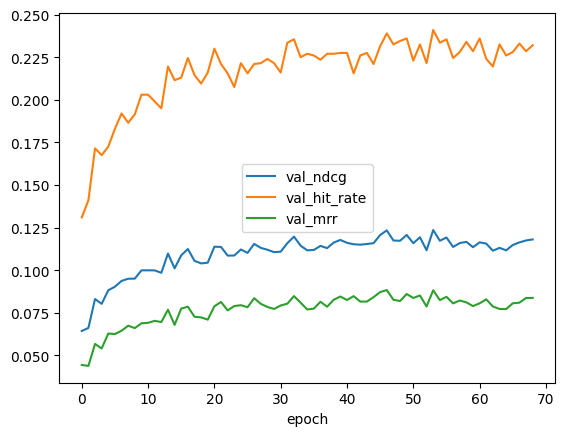

In [37]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
history.drop(columns=['step', 'time']).plot(x="epoch")

In [38]:
predict_dataset = CausalLMPredictionDataset(train, max_length=MAX_LENGTH)

predict_loader = DataLoader(
    predict_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

preds = trainer.predict(model=seqrec_module, dataloaders=predict_loader)

recs = preds2recs(preds)
print(recs.shape)
recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████| 541/541 [03:52<00:00, -6.99it/s]
(1384930, 3)


,user_id,item_id,prediction
0,1,5463,9.836947
1,1,3997,7.142198
2,1,4275,6.849681
3,1,5999,6.752532
4,1,6991,6.707426


## Predict val

In [39]:
val_users = validation.user_id.unique()
test_users = test.user_id.unique()

train_for_val = train[train.user_id.isin(val_users)]
train_for_test = train[train.user_id.isin(test_users)]

predict_for_val_dataset = CausalLMPredictionDataset(train_for_val, max_length=MAX_LENGTH)
predict_for_val_loader = DataLoader(
    predict_for_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

predict_for_test_dataset = CausalLMPredictionDataset(train_for_test, max_length=MAX_LENGTH)
predict_for_test_loader = DataLoader(
    predict_for_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

In [40]:
val_preds = trainer.predict(model=seqrec_module, dataloaders=predict_for_val_loader)
val_recs = preds2recs(val_preds)
print(val_recs.shape)
val_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 271/271 [02:19<00:00, -13.55it/s]
(692460, 3)


,user_id,item_id,prediction
0,3,2322,8.503093
1,3,172,7.911433
2,3,1591,7.648862
3,3,1373,7.578745
4,3,611,7.431586


In [41]:
%%time
evaluator = Evaluator(col_time_idx='time_idx')
val_metrics = pd.Series(evaluator.compute_metrics(validation, val_recs, train))
val_metrics

CPU times: user 49.7 s, sys: 14 s, total: 1min 3s
Wall time: 1min 3s


map@10          0.062026
ndcg@10         0.132247
recall@10       0.124751
coverage@10     0.351319
entropy@10     11.152326
novelty@10     11.599334
dtype: float64

In [42]:
evaluator.compute_metrics_by_time_idx(validation, val_recs)

,map@10,ndcg@10,recall@10
0,0.086760,0.121303,0.235855
1,0.064537,0.093826,0.191318
2,0.052645,0.078185,0.163533
3,0.045395,0.067674,0.142362
4,0.038174,0.056966,0.120151
5,0.031439,0.047282,0.100612
6,0.027776,0.042086,0.090229
7,0.022917,0.035449,0.077694
8,0.019786,0.030398,0.066170
9,0.018251,0.027701,0.059585


In [43]:
evaluator.compute_metrics_by_time_idx(validation, val_recs, top_k_gt=True)

,map@10,ndcg@10,recall@10
0,0.086760,0.121303,0.235855
1,0.083454,0.131906,0.213586
2,0.080906,0.137646,0.196902
3,0.078887,0.140923,0.183267
4,0.076491,0.141754,0.170644
5,0.073504,0.140782,0.158972
6,0.070745,0.139451,0.149151
7,0.067787,0.137290,0.140219
8,0.064740,0.134721,0.131992
9,0.062026,0.132247,0.124751


## test

In [44]:
preds_test = trainer.predict(model=seqrec_module, dataloaders=predict_for_test_loader)

test_recs = preds2recs(preds_test)
print(test_recs.shape)
test_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 271/271 [01:32<00:00, -20.55it/s]
(692470, 3)


,user_id,item_id,prediction
0,1,5463,9.836947
1,1,3997,7.142198
2,1,4275,6.849681
3,1,5999,6.752532
4,1,6991,6.707426


In [45]:
%%time
test_metrics = pd.Series(evaluator.compute_metrics(test, test_recs, train))
test_metrics

CPU times: user 48.8 s, sys: 14 s, total: 1min 2s
Wall time: 1min 2s


map@10          0.061787
ndcg@10         0.131848
recall@10       0.124309
coverage@10     0.348670
entropy@10     11.168415
novelty@10     11.617064
dtype: float64

In [46]:
evaluator.compute_metrics_by_time_idx(test, test_recs, )

,map@10,ndcg@10,recall@10
0,0.086635,0.121159,0.235664
1,0.065169,0.094819,0.193698
2,0.053419,0.078541,0.162433
3,0.044710,0.066511,0.139515
4,0.037628,0.056526,0.119976
5,0.032182,0.048379,0.102849
6,0.026827,0.041000,0.088813
7,0.023469,0.035848,0.077577
8,0.019169,0.029634,0.065028
9,0.017479,0.026644,0.057533


In [47]:
evaluator.compute_metrics_by_time_idx(test, test_recs, top_k_gt=True) 

,map@10,ndcg@10,recall@10
0,0.086635,0.121159,0.235664
1,0.083574,0.132426,0.214681
2,0.081359,0.138212,0.197265
3,0.078976,0.140939,0.182827
4,0.076397,0.141619,0.170257
5,0.073653,0.140993,0.159023
6,0.070679,0.139345,0.148993
7,0.067768,0.137293,0.140066
8,0.064630,0.134544,0.131728
9,0.061787,0.131848,0.124309
